# Import Required Libraries and Environment
Import Stable Baselines3, the custom PVPokeEnv, and other required libraries. Configure environment variables and connect to the server.

In [1]:
import asyncio
import websockets
from pydantic import BaseModel
import nest_asyncio
nest_asyncio.apply()
import json
from ClassPVPOKE import PVPokeEnv
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# Create an instance of the environment and connect to the server
env = PVPokeEnv("ws://localhost:8000/ws", "notebook", "pvpoke", battle_format="1v1")
env.loop.run_until_complete(env.connect())

# Check if the environment follows the Gym API
check_env(env)

# Close the environment connection
env.close()

Connected to the server.
WebSocket connection closed.


# Create and Configure the Agent PPO
Create and configure a Stable Baselines3 agent (like PPO or DQN) with appropriate hyperparameters for the PVPoke environment.

In [1]:
import asyncio
import nest_asyncio
import numpy as np
import os
from datetime import datetime
from ClassPVPOKE import PVPokeEnv
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
from stable_baselines3.common.monitor import Monitor
import torch

nest_asyncio.apply()

# Configuración de evaluación
EVAL_EVERY = 20000
TOTAL_TIMESTEPS = 2000000

# Parámetros para grid
architectures = [
    #([128, 128], "128x2"),
    #([256, 256], "256x2"),
    #([512, 512], "512x2"),
    #([128]*4, "128x4"),
    #([256]*4, "256x4"),
    #([512]*4, "512x4"),
    #([128]*6, "128x6"),
    ([256]*6, "256x6"),
    ([512]*6, "512x6"),
]
learning_rates = [ 1e-4]

# Info general
pokemon_matchup = "Mantine-Gligar"
battle_format = "1v1"
model_type = "DQN"
buffer = "100k"
train_frec = "4"
step = "2m"

for arch, arch_name in architectures:
    for lr in learning_rates:
        # Nombre único de experimento
        exp_id = f"{arch_name}_lr{lr}"
        experiment_name = f"{model_type}/{pokemon_matchup}_{exp_id}_{buffer}"
        log_dir = f"./logs/{battle_format}/{train_frec}/{step}/{experiment_name}"
        models_dir = f"./models/{battle_format}/{train_frec}/{step}/{model_type.lower()}/{pokemon_matchup}/{exp_id}_{buffer}"

        print(f"\nStarting experiment: {experiment_name}")
        print("cuda" if torch.cuda.is_available() else "cpu")
        os.makedirs(models_dir, exist_ok=True)

        try:
            # Conexión al entorno
            env = PVPokeEnv("ws://localhost:8000/ws", "notebook", "pvpoke", battle_format="1v1")
            env.loop.run_until_complete(env.connect())
            env = Monitor(env)

            # Definición del modelo
            model = DQN(
                policy="MlpPolicy",
                env=env,
                learning_rate=lr,
                buffer_size=100000,
                learning_starts=10000,
                batch_size=128,
                gamma=0.999,
                train_freq=4,
                gradient_steps=1,
                target_update_interval=1000,
                exploration_fraction=0.2,
                exploration_initial_eps=1.0,
                exploration_final_eps=0.05,
                tensorboard_log=log_dir,
                policy_kwargs={"net_arch": arch},
                device="cuda" if torch.cuda.is_available() else "cpu",
                
            )

            checkpoint_callback = CheckpointCallback(
                save_freq=EVAL_EVERY,
                save_path=models_dir,
                name_prefix='dqn_pvpoke'
            )

            eval_callback = EvalCallback(
                env,
                best_model_save_path=models_dir,
                log_path=log_dir,
                eval_freq=EVAL_EVERY,
                deterministic=True,
                render=False,
                verbose=0,
                n_eval_episodes=100,
            )

            # Entrenamiento
            model.learn(
                total_timesteps=TOTAL_TIMESTEPS,
                callback=[checkpoint_callback, eval_callback],
                progress_bar=True
            )

            # Guardado final
            model.save(f"{models_dir}/dqn_pvpoke_final")
            print(f"✅ Finished training {experiment_name}. Model saved.")

        except Exception as e:
            print(f"❌ Error in {experiment_name}: {e}")

        finally:
            print(f"Closing environments for {exp_id}...")
            env.close()
            



Starting experiment: DQN/Mantine-Gligar_256x6_lr0.0001_100k
cuda
Connected to the server.


Output()

✅ Finished training DQN/Mantine-Gligar_256x6_lr0.0001_100k. Model saved.
Closing environments for 256x6_lr0.0001...
WebSocket connection closed.

Starting experiment: DQN/Mantine-Gligar_512x6_lr0.0001_100k
cuda


Output()

Connected to the server.


✅ Finished training DQN/Mantine-Gligar_512x6_lr0.0001_100k. Model saved.
Closing environments for 512x6_lr0.0001...
WebSocket connection closed.


# Optimizacion con Optuna 

In [1]:
import optuna
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import numpy as np
import os
import asyncio
import nest_asyncio
import json
from ClassPVPOKE import PVPokeEnv
import torch
from datetime import datetime

# Asegurar funcionamiento de asyncio anidado
nest_asyncio.apply()

# Configuración del estudio
STUDY_NAME = "dqn_pvpoke_optuna"
N_TRIALS = 15  # Número de combinaciones de hiperparámetros a probar
TRAINING_TIMESTEPS = 100000  # Pasos de entrenamiento por prueba (reducido para búsqueda)
EVAL_EPISODES = 10  # Episodios de evaluación por prueba
POKEMON_MATCHUP = "Mantine-Gligar"
BATTLE_FORMAT = "1v1"

# Crear directorios para resultados
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
base_dir = f"./optuna_studies/{STUDY_NAME}_{timestamp}"
log_dir = f"{base_dir}/logs"
models_dir = f"{base_dir}/models"
os.makedirs(log_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

# Definir la función objetivo para optimización
def objective(trial):
    # Identificador único para esta prueba
    trial_id = f"trial_{trial.number}"
    trial_log_dir = f"{log_dir}/{trial_id}"
    trial_model_dir = f"{models_dir}/{trial_id}"
    os.makedirs(trial_log_dir, exist_ok=True)
    os.makedirs(trial_model_dir, exist_ok=True)
    
    # Espacio de búsqueda para hiperparámetros (ajustado para episodios de ~35 pasos)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-4, log=True)
    buffer_size = trial.suggest_categorical('buffer_size', [10000, 20000, 50000])
    learning_starts = trial.suggest_int('learning_starts', 500, 2000)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    gamma = trial.suggest_float('gamma', 0.98, 0.999)
    train_freq = trial.suggest_categorical('train_freq', [1, 4])
    target_update_interval = trial.suggest_int('target_update_interval', 200, 1000, step=100)
    exploration_fraction = trial.suggest_float('exploration_fraction', 0.1, 0.3)
    exploration_final_eps = trial.suggest_float('exploration_final_eps', 0.02, 0.1)
    
    # Arquitectura de la red
    net_arch_options = [
        [128, 128],
        [256, 256],
        [128, 128, 128],
        [256, 256, 256]
    ]
    net_arch = trial.suggest_categorical('net_arch', net_arch_options)
    
    print(f"\n=== Iniciando Prueba {trial.number} ===")
    print(f"Parámetros: {trial.params}")
    
    try:
        # Crear y conectar al entorno
        env = PVPokeEnv("ws://localhost:8000/ws", "notebook", "pvpoke", battle_format=BATTLE_FORMAT)
        env.loop.run_until_complete(env.connect())
        env = Monitor(env)
        
        # Crear modelo DQN con los hiperparámetros de esta prueba
        model = DQN(
            policy="MlpPolicy",
            env=env,
            learning_rate=learning_rate,
            buffer_size=buffer_size,
            learning_starts=learning_starts,
            batch_size=batch_size,
            gamma=gamma,
            train_freq=train_freq,
            gradient_steps=1,
            target_update_interval=target_update_interval,
            exploration_fraction=exploration_fraction,
            exploration_initial_eps=1.0,
            exploration_final_eps=exploration_final_eps,
            tensorboard_log=trial_log_dir,
            policy_kwargs={"net_arch": net_arch},
            device="cuda" if torch.cuda.is_available() else "cpu"
        )
        
        # Callback para evaluación periódica
        eval_callback = EvalCallback(
            env,
            best_model_save_path=trial_model_dir,
            log_path=trial_log_dir,
            eval_freq=5000,
            deterministic=True,
            render=False,
            n_eval_episodes=5,
            verbose=0
        )
        
        # Entrenar el modelo
        model.learn(
            total_timesteps=TRAINING_TIMESTEPS,
            callback=eval_callback,
            progress_bar=True
        )
        
        # Evaluación final
        mean_reward, std_reward = evaluate_policy(
            model, 
            env, 
            n_eval_episodes=EVAL_EPISODES,
            deterministic=True
        )
        
        # Guardar modelo final
        model.save(f"{trial_model_dir}/final_model")
        
        # Reportar métricas
        print(f"Prueba {trial.number} - Recompensa media: {mean_reward:.2f} ± {std_reward:.2f}")
        
        # Registrar métricas adicionales
        with open(f"{trial_model_dir}/results.json", "w") as f:
            json.dump({
                "trial_number": trial.number,
                "params": {k: str(v) if isinstance(v, list) else v for k, v in trial.params.items()},
                "mean_reward": float(mean_reward),
                "std_reward": float(std_reward)
            }, f)
        
        return mean_reward
        
    except Exception as e:
        print(f"Error en prueba {trial.number}: {e}")
        return float('-inf')  # Peor valor posible en caso de error
        
    finally:
        # Siempre cerrar el entorno para liberar recursos
        try:
            env.close()
            print(f"Entorno cerrado para prueba {trial.number}")
        except:
            pass

# Crear estudio para optimización
study = optuna.create_study(
    study_name=STUDY_NAME,
    direction="maximize",  # Maximizar recompensa
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)  # Detener pruebas poco prometedoras
)

# Iniciar proceso de optimización
print(f"Iniciando optimización con {N_TRIALS} pruebas")
study.optimize(objective, n_trials=N_TRIALS)

# Imprimir y guardar resultados
print("\n=== Optimización Completada ===")
print(f"Mejor prueba: {study.best_trial.number}")
print(f"Mejor recompensa: {study.best_value:.4f}")
print(f"Mejores hiperparámetros: {study.best_params}")

# Guardar mejores hiperparámetros
with open(f"{base_dir}/best_params.json", "w") as f:
    json.dump({
        "best_trial": study.best_trial.number,
        "best_reward": float(study.best_value),
        "best_params": {k: str(v) if isinstance(v, list) else v for k, v in study.best_params.items()}
    }, f, indent=2)

print(f"Resultados guardados en {base_dir}")

# Código para crear modelo final con mejores hiperparámetros
print("\n=== Entrenamiento Final con Mejores Hiperparámetros ===")
try:
    # Crear entorno para entrenamiento final
    env = PVPokeEnv("ws://localhost:8000/ws", "notebook", "pvpoke", battle_format=BATTLE_FORMAT)
    env.loop.run_until_complete(env.connect())
    env = Monitor(env)
    
    # Copiar mejores parámetros (para manipularlos)
    best_params = study.best_params.copy()
    
    # Extraer arquitectura de red (que es una lista)
    net_arch = best_params.pop('net_arch')
    
    # Crear modelo con mejores hiperparámetros
    best_model = DQN(
        policy="MlpPolicy",
        env=env,
        **best_params,  # Desempaquetar mejores hiperparámetros
        policy_kwargs={"net_arch": net_arch},
        tensorboard_log=f"{base_dir}/final_model_logs",
        device="cuda" if torch.cuda.is_available() else "cpu"
    )
    
    # Entrenar modelo final por más tiempo
    best_model.learn(
        total_timesteps=1000000,  # Entrenar por más tiempo
        progress_bar=True
    )
    
    # Guardar modelo final
    final_model_path = f"{base_dir}/dqn_pvpoke_final_{POKEMON_MATCHUP}_optuna"
    best_model.save(final_model_path)
    print(f"Modelo final guardado en {final_model_path}")
    
except Exception as e:
    print(f"Error en entrenamiento final: {e}")

finally:
    # Cerrar entorno
    env.close()

[I 2025-04-28 10:37:14,752] A new study created in memory with name: dqn_pvpoke_optuna
c:\Users\samue\miniconda3\envs\gym\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\samue\miniconda3\envs\gym\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\samue\miniconda3\envs\gym\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128, 128] which is of type list.
  warnings.warn(message)
c:\Users\samue\miniconda3\envs\gym\Lib\site-packages\optuna\distr

Iniciando optimización con 15 pruebas

=== Iniciando Prueba 0 ===
Parámetros: {'learning_rate': 0.0002769652880017355, 'buffer_size': 50000, 'learning_starts': 1361, 'batch_size': 32, 'gamma': 0.9863536870153633, 'train_freq': 4, 'target_update_interval': 200, 'exploration_fraction': 0.24416303764104672, 'exploration_final_eps': 0.0352729208634948, 'net_arch': [256, 256]}
Connected to the server.


Output()

[I 2025-04-28 10:49:31,389] Trial 0 finished with value: -1.7576924999999999 and parameters: {'learning_rate': 0.0002769652880017355, 'buffer_size': 50000, 'learning_starts': 1361, 'batch_size': 32, 'gamma': 0.9863536870153633, 'train_freq': 4, 'target_update_interval': 200, 'exploration_fraction': 0.24416303764104672, 'exploration_final_eps': 0.0352729208634948, 'net_arch': [256, 256]}. Best is trial 0 with value: -1.7576924999999999.


Prueba 0 - Recompensa media: -1.76 ± 0.12
WebSocket connection closed.
Entorno cerrado para prueba 0

=== Iniciando Prueba 1 ===
Parámetros: {'learning_rate': 0.00020329643334753301, 'buffer_size': 20000, 'learning_starts': 1613, 'batch_size': 32, 'gamma': 0.9839722894117535, 'train_freq': 4, 'target_update_interval': 800, 'exploration_fraction': 0.23518708110981204, 'exploration_final_eps': 0.07239082022843095, 'net_arch': [128, 128]}


c:\Users\samue\miniconda3\envs\gym\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\samue\miniconda3\envs\gym\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\samue\miniconda3\envs\gym\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128, 128] which is of type list.
  warnings.warn(message)
c:\Users\samue\miniconda3\envs\gym\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple 

Output()

[I 2025-04-28 11:00:04,635] Trial 1 finished with value: -1.8823073000000001 and parameters: {'learning_rate': 0.00020329643334753301, 'buffer_size': 20000, 'learning_starts': 1613, 'batch_size': 32, 'gamma': 0.9839722894117535, 'train_freq': 4, 'target_update_interval': 800, 'exploration_fraction': 0.23518708110981204, 'exploration_final_eps': 0.07239082022843095, 'net_arch': [128, 128]}. Best is trial 0 with value: -1.7576924999999999.


Prueba 1 - Recompensa media: -1.88 ± 0.01
WebSocket connection closed.
Entorno cerrado para prueba 1

=== Iniciando Prueba 2 ===
Parámetros: {'learning_rate': 0.0002126835385636654, 'buffer_size': 20000, 'learning_starts': 1572, 'batch_size': 32, 'gamma': 0.983206386839582, 'train_freq': 4, 'target_update_interval': 700, 'exploration_fraction': 0.2527628569570819, 'exploration_final_eps': 0.0344401750720791, 'net_arch': [128, 128, 128]}


Output()

Connected to the server.


[I 2025-04-28 11:11:30,543] Trial 2 finished with value: -1.9538459999999997 and parameters: {'learning_rate': 0.0002126835385636654, 'buffer_size': 20000, 'learning_starts': 1572, 'batch_size': 32, 'gamma': 0.983206386839582, 'train_freq': 4, 'target_update_interval': 700, 'exploration_fraction': 0.2527628569570819, 'exploration_final_eps': 0.0344401750720791, 'net_arch': [128, 128, 128]}. Best is trial 0 with value: -1.7576924999999999.


Prueba 2 - Recompensa media: -1.95 ± 0.00
WebSocket connection closed.
Entorno cerrado para prueba 2

=== Iniciando Prueba 3 ===
Parámetros: {'learning_rate': 0.0002900584347262353, 'buffer_size': 20000, 'learning_starts': 1840, 'batch_size': 128, 'gamma': 0.9847659218699816, 'train_freq': 4, 'target_update_interval': 900, 'exploration_fraction': 0.1265120133579294, 'exploration_final_eps': 0.041049006361395565, 'net_arch': [256, 256, 256]}


Output()

Connected to the server.


[I 2025-04-28 11:25:28,061] Trial 3 finished with value: -1.7830768 and parameters: {'learning_rate': 0.0002900584347262353, 'buffer_size': 20000, 'learning_starts': 1840, 'batch_size': 128, 'gamma': 0.9847659218699816, 'train_freq': 4, 'target_update_interval': 900, 'exploration_fraction': 0.1265120133579294, 'exploration_final_eps': 0.041049006361395565, 'net_arch': [256, 256, 256]}. Best is trial 0 with value: -1.7576924999999999.


Prueba 3 - Recompensa media: -1.78 ± 0.10
WebSocket connection closed.
Entorno cerrado para prueba 3

=== Iniciando Prueba 4 ===
Parámetros: {'learning_rate': 0.00027425860905154616, 'buffer_size': 50000, 'learning_starts': 625, 'batch_size': 64, 'gamma': 0.9945812824181031, 'train_freq': 4, 'target_update_interval': 500, 'exploration_fraction': 0.1590347366647204, 'exploration_final_eps': 0.09831641578100747, 'net_arch': [128, 128, 128]}


Output()

Connected to the server.


[I 2025-04-28 11:38:34,582] Trial 4 finished with value: -1.6915382 and parameters: {'learning_rate': 0.00027425860905154616, 'buffer_size': 50000, 'learning_starts': 625, 'batch_size': 64, 'gamma': 0.9945812824181031, 'train_freq': 4, 'target_update_interval': 500, 'exploration_fraction': 0.1590347366647204, 'exploration_final_eps': 0.09831641578100747, 'net_arch': [128, 128, 128]}. Best is trial 4 with value: -1.6915382.


Prueba 4 - Recompensa media: -1.69 ± 0.05
WebSocket connection closed.
Entorno cerrado para prueba 4

=== Iniciando Prueba 5 ===
Parámetros: {'learning_rate': 0.00044536718617693813, 'buffer_size': 10000, 'learning_starts': 1198, 'batch_size': 64, 'gamma': 0.9819027797057402, 'train_freq': 1, 'target_update_interval': 300, 'exploration_fraction': 0.17552302564914704, 'exploration_final_eps': 0.04894852099120832, 'net_arch': [256, 256]}


Output()

Connected to the server.


[I 2025-04-28 11:58:36,821] Trial 5 finished with value: -1.6661536000000001 and parameters: {'learning_rate': 0.00044536718617693813, 'buffer_size': 10000, 'learning_starts': 1198, 'batch_size': 64, 'gamma': 0.9819027797057402, 'train_freq': 1, 'target_update_interval': 300, 'exploration_fraction': 0.17552302564914704, 'exploration_final_eps': 0.04894852099120832, 'net_arch': [256, 256]}. Best is trial 5 with value: -1.6661536000000001.


Prueba 5 - Recompensa media: -1.67 ± 0.12
WebSocket connection closed.
Entorno cerrado para prueba 5

=== Iniciando Prueba 6 ===
Parámetros: {'learning_rate': 0.00029525764668225435, 'buffer_size': 10000, 'learning_starts': 647, 'batch_size': 128, 'gamma': 0.9803990118930473, 'train_freq': 4, 'target_update_interval': 200, 'exploration_fraction': 0.17950997950630015, 'exploration_final_eps': 0.09161446176803974, 'net_arch': [128, 128]}


Output()

Connected to the server.


[I 2025-04-28 12:10:44,103] Trial 6 finished with value: -1.7584616 and parameters: {'learning_rate': 0.00029525764668225435, 'buffer_size': 10000, 'learning_starts': 647, 'batch_size': 128, 'gamma': 0.9803990118930473, 'train_freq': 4, 'target_update_interval': 200, 'exploration_fraction': 0.17950997950630015, 'exploration_final_eps': 0.09161446176803974, 'net_arch': [128, 128]}. Best is trial 5 with value: -1.6661536000000001.


Prueba 6 - Recompensa media: -1.76 ± 0.10
WebSocket connection closed.
Entorno cerrado para prueba 6

=== Iniciando Prueba 7 ===
Parámetros: {'learning_rate': 0.00011113732984144203, 'buffer_size': 20000, 'learning_starts': 1345, 'batch_size': 32, 'gamma': 0.9919418670231126, 'train_freq': 1, 'target_update_interval': 800, 'exploration_fraction': 0.2864075345230672, 'exploration_final_eps': 0.05281606207195465, 'net_arch': [128, 128, 128]}


Output()

Connected to the server.


[I 2025-04-28 12:28:39,893] Trial 7 finished with value: -0.27155120000000005 and parameters: {'learning_rate': 0.00011113732984144203, 'buffer_size': 20000, 'learning_starts': 1345, 'batch_size': 32, 'gamma': 0.9919418670231126, 'train_freq': 1, 'target_update_interval': 800, 'exploration_fraction': 0.2864075345230672, 'exploration_final_eps': 0.05281606207195465, 'net_arch': [128, 128, 128]}. Best is trial 7 with value: -0.27155120000000005.


Prueba 7 - Recompensa media: -0.27 ± 1.30
WebSocket connection closed.
Entorno cerrado para prueba 7

=== Iniciando Prueba 8 ===
Parámetros: {'learning_rate': 0.00011625567383985442, 'buffer_size': 10000, 'learning_starts': 1629, 'batch_size': 32, 'gamma': 0.9826077927514182, 'train_freq': 4, 'target_update_interval': 400, 'exploration_fraction': 0.11015447470974996, 'exploration_final_eps': 0.08450454918382569, 'net_arch': [128, 128]}


Output()

Connected to the server.


[I 2025-04-28 12:39:47,011] Trial 8 finished with value: -1.6615379999999997 and parameters: {'learning_rate': 0.00011625567383985442, 'buffer_size': 10000, 'learning_starts': 1629, 'batch_size': 32, 'gamma': 0.9826077927514182, 'train_freq': 4, 'target_update_interval': 400, 'exploration_fraction': 0.11015447470974996, 'exploration_final_eps': 0.08450454918382569, 'net_arch': [128, 128]}. Best is trial 7 with value: -0.27155120000000005.


Prueba 8 - Recompensa media: -1.66 ± 0.00
WebSocket connection closed.
Entorno cerrado para prueba 8

=== Iniciando Prueba 9 ===
Parámetros: {'learning_rate': 0.00044373212683403266, 'buffer_size': 50000, 'learning_starts': 1889, 'batch_size': 32, 'gamma': 0.992670240055762, 'train_freq': 1, 'target_update_interval': 500, 'exploration_fraction': 0.26842569382031006, 'exploration_final_eps': 0.05133591830671913, 'net_arch': [256, 256]}


Output()

Connected to the server.


[I 2025-04-28 12:59:20,225] Trial 9 finished with value: -1.6884615 and parameters: {'learning_rate': 0.00044373212683403266, 'buffer_size': 50000, 'learning_starts': 1889, 'batch_size': 32, 'gamma': 0.992670240055762, 'train_freq': 1, 'target_update_interval': 500, 'exploration_fraction': 0.26842569382031006, 'exploration_final_eps': 0.05133591830671913, 'net_arch': [256, 256]}. Best is trial 7 with value: -0.27155120000000005.


Prueba 9 - Recompensa media: -1.69 ± 0.10
WebSocket connection closed.
Entorno cerrado para prueba 9

=== Iniciando Prueba 10 ===
Parámetros: {'learning_rate': 0.00010448061120979998, 'buffer_size': 20000, 'learning_starts': 1177, 'batch_size': 64, 'gamma': 0.9980347542563842, 'train_freq': 1, 'target_update_interval': 1000, 'exploration_fraction': 0.298399038540478, 'exploration_final_eps': 0.07067158133357831, 'net_arch': [128, 128, 128]}


Output()

Connected to the server.


[I 2025-04-28 13:17:43,040] Trial 10 finished with value: -1.5584618 and parameters: {'learning_rate': 0.00010448061120979998, 'buffer_size': 20000, 'learning_starts': 1177, 'batch_size': 64, 'gamma': 0.9980347542563842, 'train_freq': 1, 'target_update_interval': 1000, 'exploration_fraction': 0.298399038540478, 'exploration_final_eps': 0.07067158133357831, 'net_arch': [128, 128, 128]}. Best is trial 7 with value: -0.27155120000000005.


Prueba 10 - Recompensa media: -1.56 ± 0.11
WebSocket connection closed.
Entorno cerrado para prueba 10

=== Iniciando Prueba 11 ===
Parámetros: {'learning_rate': 0.00010332267955044316, 'buffer_size': 20000, 'learning_starts': 995, 'batch_size': 64, 'gamma': 0.9986216755038884, 'train_freq': 1, 'target_update_interval': 1000, 'exploration_fraction': 0.29561531533304036, 'exploration_final_eps': 0.06430917107987116, 'net_arch': [128, 128, 128]}


Output()

Connected to the server.


[I 2025-04-28 13:36:31,093] Trial 11 finished with value: -1.6115381 and parameters: {'learning_rate': 0.00010332267955044316, 'buffer_size': 20000, 'learning_starts': 995, 'batch_size': 64, 'gamma': 0.9986216755038884, 'train_freq': 1, 'target_update_interval': 1000, 'exploration_fraction': 0.29561531533304036, 'exploration_final_eps': 0.06430917107987116, 'net_arch': [128, 128, 128]}. Best is trial 7 with value: -0.27155120000000005.


Prueba 11 - Recompensa media: -1.61 ± 0.10
WebSocket connection closed.
Entorno cerrado para prueba 11

=== Iniciando Prueba 12 ===
Parámetros: {'learning_rate': 0.00014442425236346925, 'buffer_size': 20000, 'learning_starts': 985, 'batch_size': 64, 'gamma': 0.9981616742798969, 'train_freq': 1, 'target_update_interval': 1000, 'exploration_fraction': 0.2970656780851614, 'exploration_final_eps': 0.0766722739148692, 'net_arch': [128, 128, 128]}


Output()

Connected to the server.


[I 2025-04-28 13:55:07,619] Trial 12 finished with value: -1.6476922999999999 and parameters: {'learning_rate': 0.00014442425236346925, 'buffer_size': 20000, 'learning_starts': 985, 'batch_size': 64, 'gamma': 0.9981616742798969, 'train_freq': 1, 'target_update_interval': 1000, 'exploration_fraction': 0.2970656780851614, 'exploration_final_eps': 0.0766722739148692, 'net_arch': [128, 128, 128]}. Best is trial 7 with value: -0.27155120000000005.


Prueba 12 - Recompensa media: -1.65 ± 0.02
WebSocket connection closed.
Entorno cerrado para prueba 12

=== Iniciando Prueba 13 ===
Parámetros: {'learning_rate': 0.00014535714135395687, 'buffer_size': 20000, 'learning_starts': 1250, 'batch_size': 64, 'gamma': 0.9896655641256908, 'train_freq': 1, 'target_update_interval': 800, 'exploration_fraction': 0.21158850207797938, 'exploration_final_eps': 0.021344527526953753, 'net_arch': [128, 128, 128]}


Output()

Connected to the server.


[I 2025-04-28 14:13:05,004] Trial 13 finished with value: -1.7261541999999999 and parameters: {'learning_rate': 0.00014535714135395687, 'buffer_size': 20000, 'learning_starts': 1250, 'batch_size': 64, 'gamma': 0.9896655641256908, 'train_freq': 1, 'target_update_interval': 800, 'exploration_fraction': 0.21158850207797938, 'exploration_final_eps': 0.021344527526953753, 'net_arch': [128, 128, 128]}. Best is trial 7 with value: -0.27155120000000005.


Prueba 13 - Recompensa media: -1.73 ± 0.07
WebSocket connection closed.
Entorno cerrado para prueba 13

=== Iniciando Prueba 14 ===
Parámetros: {'learning_rate': 0.00013616096340685716, 'buffer_size': 20000, 'learning_starts': 927, 'batch_size': 128, 'gamma': 0.9949759137517417, 'train_freq': 1, 'target_update_interval': 700, 'exploration_fraction': 0.27658933467168667, 'exploration_final_eps': 0.06172002409980354, 'net_arch': [256, 256, 256]}


Output()

Connected to the server.


[I 2025-04-28 14:42:14,164] Trial 14 finished with value: -1.5923079999999998 and parameters: {'learning_rate': 0.00013616096340685716, 'buffer_size': 20000, 'learning_starts': 927, 'batch_size': 128, 'gamma': 0.9949759137517417, 'train_freq': 1, 'target_update_interval': 700, 'exploration_fraction': 0.27658933467168667, 'exploration_final_eps': 0.06172002409980354, 'net_arch': [256, 256, 256]}. Best is trial 7 with value: -0.27155120000000005.


Prueba 14 - Recompensa media: -1.59 ± 0.00
WebSocket connection closed.
Entorno cerrado para prueba 14

=== Optimización Completada ===
Mejor prueba: 7
Mejor recompensa: -0.2716
Mejores hiperparámetros: {'learning_rate': 0.00011113732984144203, 'buffer_size': 20000, 'learning_starts': 1345, 'batch_size': 32, 'gamma': 0.9919418670231126, 'train_freq': 1, 'target_update_interval': 800, 'exploration_fraction': 0.2864075345230672, 'exploration_final_eps': 0.05281606207195465, 'net_arch': [128, 128, 128]}
Resultados guardados en ./optuna_studies/dqn_pvpoke_optuna_20250428_103714

=== Entrenamiento Final con Mejores Hiperparámetros ===


Output()

Connected to the server.


Modelo final guardado en ./optuna_studies/dqn_pvpoke_optuna_20250428_103714/dqn_pvpoke_final_Mantine-Gligar_optuna
WebSocket connection closed.


In [ ]:
# Import required libraries
import asyncio
import nest_asyncio
import numpy as np
import os
from datetime import datetime
from ClassPVPOKE import PVPokeEnv
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
from stable_baselines3.common.monitor import Monitor
import torch

# Apply nest_asyncio to avoid asyncio event loop issues
nest_asyncio.apply()

# Create experiment directory with timestamp
# Define descriptive experiment naming
pokemon_matchup = "Mantine-Gligar"

battle_format = "1v1"
model_type = "DQN"  
network_arch = "128-128-128"
version = "v2"
buffer = "100k"
step = "1m"
train_frec = "1"

# Build more meaningful directory structure
experiment_name = f"{model_type}/{pokemon_matchup}_{network_arch}_{buffer}"
log_dir = f"./logs/{battle_format}/{train_frec}/{step}/{experiment_name}"
models_dir = f"./models/{battle_format}/{train_frec}/{step}/{model_type.lower()}/{pokemon_matchup}/{network_arch}_{buffer}_{version}"

print(f"Starting DQN training: {experiment_name}")
print(f"Logs will be saved to: {log_dir}")
print(f"Models will be saved to: {models_dir}")
print(f"CUda available: {torch.cuda.is_available()}")
try:
    # Create and connect to environment
    env = PVPokeEnv("ws://localhost:8000/ws", "notebook", "pvpoke", battle_format="1v1")
    env.loop.run_until_complete(env.connect())
    env = Monitor(env)
    
    # Set up the DQN agent
    model = DQN(
        policy="MlpPolicy",
        env=env,
        learning_rate=1e-3,             # Slightly lower to ensure stable learning
        buffer_size=100000,             # Sufficient for your state space, smaller than 250k
        learning_starts=2000,           # Allow collecting more diverse experiences before learning
        batch_size=128,                 # Good balance for your use case
        gamma=0.999,                     # Standard discount factor for short episodes
        train_freq=4,                   # Update every step for more frequent learning
        gradient_steps=1,
        target_update_interval=500,     # More frequent target updates
        exploration_fraction=0.2,       # Explore more at the beginning
        exploration_initial_eps=1.0,
        exploration_final_eps=0.05,     # Slightly higher to maintain some exploration
        tensorboard_log=log_dir,
        policy_kwargs={"net_arch": [128, 128,128]},  # Larger network for the complex game logic
        device="cuda" if torch.cuda.is_available() else "cpu",
    )
    
    # Save checkpoints during training
    checkpoint_callback = CheckpointCallback(
        save_freq=5000,                    # Save every 5000 steps
        save_path=models_dir,
        name_prefix='dqn_pvpoke'
    )
    
    # Train the agent
    print("Starting training...")
    model.learn(
        total_timesteps=2000000,
        callback=checkpoint_callback,
        progress_bar=True
    )
    
    # Save the final model
    final_model_path = f"{models_dir}/dqn_pvpoke_final"
    model.save(final_model_path)
    print(f"Training completed. Final model saved to {final_model_path}")

except Exception as e:
    print(f"An error occurred during training: {e}")

finally:
    # Always close the environment
    print("Closing environment...")
    env.close()
    print("Training session ended.")

Starting DQN training: DQN/Mantine-Gligar_128-128-128_100k
Logs will be saved to: ./logs/1v1/1/1m/DQN/Mantine-Gligar_128-128-128_100k
Models will be saved to: ./models/1v1/1/1m/dqn/Mantine-Gligar/128-128-128_100k_v2
Connected to the server.


Output()

Starting training...


Training completed. Final model saved to ./models/1v1/1/1m/dqn/Mantine-Gligar/128-128-128_100k_v2/dqn_pvpoke_final
Closing environment...
WebSocket connection closed.
Training session ended.


In [ ]:
import asyncio
import nest_asyncio
nest_asyncio.apply()
from ClassPVPOKE import PVPokeEnv
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback

env = PVPokeEnv("ws://localhost:8000/ws", "notebook", "pvpoke")
env.loop.run_until_complete(env.connect())

model = PPO(
    policy="MlpPolicy",
    env=env,
    learning_rate=3e-4,
    n_steps=128,
    batch_size=64,
    n_epochs=10,
    gamma=0.999,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    tensorboard_log="./experiments/Mantine-Gligar-Terminal-1/DQN/1v1/5lvl/128",
    policy_kwargs={"net_arch": [128, 128]}  
)

# Guardar checkpoints regularmente
checkpoint_callback = CheckpointCallback(
    save_freq=5000, 
    save_path='./models/ppo/mandibuzz-Annihilape', 
    name_prefix='ppo_pvpoke_1v1'
)

# Entrenar con los parámetros ajustados
model.learn(total_timesteps=200000, callback=checkpoint_callback, progress_bar=True)

# Guardar el modelo final
model.save("ppo_pvpoke_final_mandibuzz-Annihilape")

# Close the environment connection
env.close()

Connected to the server.


Output()

In [ ]:
# Import required libraries
import asyncio
import websockets
from pydantic import BaseModel
import nest_asyncio
nest_asyncio.apply()
import json
from ClassPVPOKE import PVPokeEnv
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

# Crear y conectar el entorno
env = PVPokeEnv("ws://localhost:8000/ws", "notebook", "pvpoke")
env.loop.run_until_complete(env.connect())



# ✅ Crear el modelo DQN con la red personalizada
model = DQN(
    policy="MlpPolicy",
    env=env,
    learning_rate=1e-3,              # Aprendizaje ajustado para 1v1
    buffer_size=50000,               # Tamaño de buffer aumentado para estabilidad
    learning_starts=1000,            # Más pasos antes de comenzar el aprendizaje
    batch_size=128,                  # Tamaño de batch ideal para 1v1
    gamma=0.99,                      # Factor de descuento a largo plazo
    train_freq=4,                    # Actualización cada 4 pasos
    gradient_steps=1,                # Un paso de gradiente por actualización
    target_update_interval=1000,     # Actualización del target más frecuente
    exploration_fraction=0.1,        
    exploration_initial_eps=1.0,     
    exploration_final_eps=0.05,      
    tensorboard_log="./dqn_pvpoke_tensorboard/mandibuzz-Annihilape",
    policy_kwargs={"net_arch": [128, 128]}  # ✅ Especificando la red de 128-128
)

# ✅ Callback para guardar checkpoints cada 5000 steps
checkpoint_callback = CheckpointCallback(
    save_freq=5000, 
    save_path='./models/dqn/mandibuzz-Annihilape', 
    name_prefix='dqn_pvpoke'
)

# ✅ Entrenar el modelo con los nuevos ajustes
model.learn(total_timesteps=200000, callback=checkpoint_callback, progress_bar=True)

# ✅ Guardar el modelo final
model.save("dqn_pvpoke_final_mandibuzz-Annihilape")

# Cerrar el entorno al finalizar
env.close()


Connected to the server.


Output()

# Entrenar DQN


In [ ]:
# Import required libraries
import asyncio
import websockets
from pydantic import BaseModel
import nest_asyncio
nest_asyncio.apply()
import json
from ClassPVPOKE import PVPokeEnv
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

# Create and connect environment
env = PVPokeEnv("ws://localhost:8000/ws", "notebook", "pvpoke")
env.loop.run_until_complete(env.connect())

# Create DQN agent with appropriate hyperparameters
model = DQN(
    "MlpPolicy",
    env,
    learning_rate=1e-3,  # Aumentar la tasa de aprendizaje
    buffer_size=50000,  # Reducir el tamaño del buffer
    learning_starts=100,  # Reducir el número de pasos antes de empezar a aprender
    batch_size=128,  # Reducir el tamaño del batch
    gamma=0.99,
    train_freq=4,
    gradient_steps=1,
    target_update_interval=1000,  # Reducir el intervalo de actualización del objetivo
    exploration_fraction=0.1,
    exploration_initial_eps=1,
    exploration_final_eps=0.05,    
    tensorboard_log="./dqn_pvpoke_tensorboard/3v3/Skar-TA-SA-BRB-Swampert-MS-HC-SW-Umbreon-SN-LR-FP-Trev-SC-SeB-SD-Vigp-Co-BS-RS-Dewgong-Is-IW-DR"
)
# Create checkpoint callback
checkpoint_callback = CheckpointCallback(save_freq=5000, 
                                         save_path='./models/dqn/3v3/Skar-TA-SA-BRB-Swampert-MS-HC-SW-Umbreon-SN-LR-FP-Trev-SC-SeB-SD-Vigp-Co-BS-RS-Dewgong-Is-IW-DR"',
                                         name_prefix='dqn_pvpoke')

# Train the agent
model.learn(total_timesteps = 200000, callback=checkpoint_callback, progress_bar=False)

# Save final model
model.save("dqn_pvpoke_final_Skar-TA-SA-BRB-Swampert-MS-HC-SW-Umbreon-SN-LR-FP-Trev-SC-SeB-SD-Vigp-Co-BS-RS-Dewgong-Is-IW-DR")

env.close()

Connected to the server.


OSError: [WinError 123] El nombre de archivo, el nombre de directorio o la sintaxis de la etiqueta del volumen no son correctos: './models/dqn/Skar-TA-SA-BRB-Swampert-MS-HC-SW-Umbreon-SN-LR-FP-Trev-SC-SeB-SD-Vigp-Co-BS-RS-Dewgong-Is-IW-DR"'

# Probar el agente en un episodio.

Connected to the server.
Loaded model from C:\pvpokeDRL\pvpoke\PVPOKE\models\1v1\1\500k\dqn\Mantine-Gligar\128-128-128_100k_v2\dqn_pvpoke_final.zip

Episode 1 started
Initial observation: [0 5 1 0 5 1]

Action taken: 0
Observation: [0 5 1 0 5 1]
Reward: -0.0015132408575031508

Action taken: 0
Observation: [1 5 1 1 5 1]
Reward: -0.0015132408575031508

Action taken: 0
Observation: [1 5 1 1 5 1]
Reward: -0.0015132408575031508

Action taken: 0
Observation: [2 5 1 2 5 1]
Reward: -0.0015132408575031508

Action taken: 0
Observation: [2 4 1 2 4 1]
Reward: -0.0015132408575031508

Action taken: 0
Observation: [2 3 1 0 4 1]
Reward: -0.23770491803278687

Action taken: 0
Observation: [2 3 1 0 4 1]
Reward: 0.023076923076923078

Action taken: 0
Observation: [3 3 1 0 4 1]
Reward: -0.0015132408575031508

Action taken: 0
Observation: [3 3 1 1 4 1]
Reward: -0.0015132408575031508

Action taken: 0
Observation: [4 3 1 1 4 1]
Reward: -0.0015132408575031508

Action taken: 0
Observation: [4 3 1 2 4 1]
Reward: 

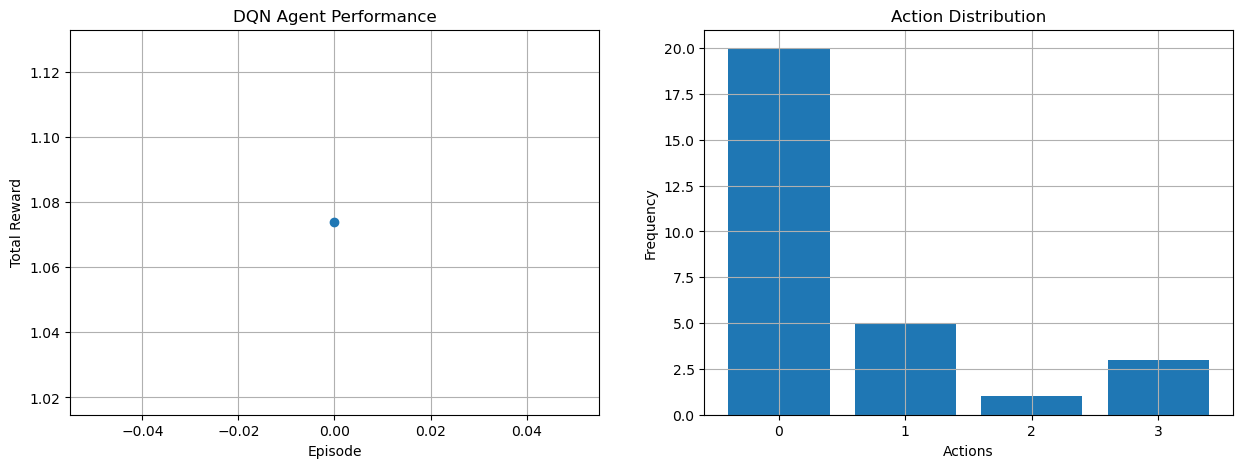

WebSocket connection closed.


In [ ]:
import asyncio
import websockets
import json
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback
import numpy as np
from ClassPVPOKE import PVPokeEnv
from stable_baselines3 import DQN
import matplotlib.pyplot as plt
import nest_asyncio 
nest_asyncio.apply()


# Create and connect environment
env = PVPokeEnv("ws://localhost:8000/ws", "notebook", "pvpoke",battle_format="1v1")
env.loop.run_until_complete(env.connect())

# Load pre-trained model
model_path = "C:\pvpokeDRL\pvpoke\PVPOKE\models\\1v1\\1\\500k\dqn\Mantine-Gligar\\128-128-128_100k_v2\dqn_pvpoke_final.zip"
model = DQN.load(model_path)

#model_path  = "C:\pvpokeDRL\pvpoke\PVPOKE\models\ppo\mandibuzz-Annihilape\ppo_pvpoke_1v1_140000_steps.zip"
#model = PPO.load(model_path)
print(f"Loaded model from {model_path}")

# Test model performance with debugging
rewards = []
actions_taken = []
observations = []

for episode in range(1):
    obs, info = env.reset()
    print(f"\nEpisode {episode + 1} started")
    print(f"Initial observation: {obs}")
    
    
    done = False
    total_reward = 0
    episode_actions = []
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        episode_actions.append(action)
        print(f"\nAction taken: {action}")
        
        obs, reward, done, terminated, info = env.step(action)
        print(f"Observation: {obs}")
        print(f"Reward: {reward}")
        
        total_reward += reward
        observations.append(obs)
    
    print(f"\nEpisode finished with total reward: {total_reward}")
    print(f"Actions taken in episode: {episode_actions}")
    rewards.append(total_reward)
    actions_taken.extend(episode_actions)

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Agent Performance')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(actions_taken, bins=np.arange(env.action_space.n + 1) - 0.5, align="mid", rwidth=0.8)
plt.xticks(np.arange(env.action_space.n))
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.title('Action Distribution')
plt.grid(True)
plt.show()

# Close environment
env.close()

In [ ]:
import asyncio
import numpy as np
from stable_baselines3 import DQN
from ClassPVPOKE import PVPokeEnv

# Create environment
env = PVPokeEnv("ws://localhost:8000/ws", "notebook", "pvpoke")
env.loop.run_until_complete(env.connect())

# Print environment specs
print("Environment Specifications:")
print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space}")

# Load model and print architecture
model_path = "dqn_pvpoke_final_mantine-gligar_optuna"
try:
    model = DQN.load(model_path, env=env)
    print("\nModel Architecture:")
    print(model.policy)
except Exception as e:
    print(f"Error loading model: {e}")

# Test single prediction
try:
    obs, _ = env.reset()
    print("\nTest Prediction:")
    print(f"Observation shape: {obs.shape}")
    action, _states = model.predict(obs, deterministic=True)
    print(f"Predicted action: {action}")
except Exception as e:
    print(f"Error during prediction: {e}")

env.close()

Connected to the server.
Environment Specifications:
Observation Space: Box(0.0, 255.0, (8,), float32)
Action Space: Discrete(4)

Model Architecture:
DQNPolicy(
  (q_net): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=4, bias=True)
    )
  )
)
Sending message: reset

Test Prediction:
Observation shape: (8,)
Predicted act

# OPTUNA

In [ ]:
import optuna
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
import asyncio
import websockets
from pydantic import BaseModel
import nest_asyncio
nest_asyncio.apply()
import json
from ClassPVPOKE import PVPokeEnv

# Define the objective function
def objective(trial):
    # Define the hyperparameter search space
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    buffer_size = trial.suggest_int('buffer_size', 10000, 100000)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    gamma = trial.suggest_uniform('gamma', 0.9, 0.999)
    exploration_fraction = trial.suggest_uniform('exploration_fraction', 0.1, 0.5)
    exploration_final_eps = trial.suggest_uniform('exploration_final_eps', 0.01, 0.1)
    
    # Create and connect environment
    env = PVPokeEnv("ws://localhost:8000/ws", "notebook", "pvpoke")
    env.loop.run_until_complete(env.connect())
    
    # Create the DQN model
    model = DQN(
        "MlpPolicy",
        env,
        learning_rate=learning_rate,
        buffer_size=buffer_size,
        learning_starts=500,
        batch_size=batch_size,
        gamma=gamma,
        train_freq=4,
        gradient_steps=1,
        target_update_interval=500,
        exploration_fraction=exploration_fraction,
        exploration_initial_eps=1.0,
        exploration_final_eps=exploration_final_eps,
        tensorboard_log="./dqn_pvpoke_tensorboard/"
    )
    
    # Create evaluation callback
    eval_callback = EvalCallback(env, best_model_save_path='./logs/',
                                 log_path='./logs/', eval_freq=500,
                                 deterministic=True, render=False)
    
    # Train the model
    model.learn(total_timesteps=10000, callback=eval_callback)
    
    # Evaluate the model
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
    
    # Close the environment
    env.close()
    
    return mean_reward

# Create the study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-12-28 11:51:52,284] A new study created in memory with name: no-name-cf637b24-c188-4629-bac1-95c458b508dd
C:\Users\samue\AppData\Local\Temp\ipykernel_31864\890825868.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\samue\AppData\Local\Temp\ipykernel_31864\890825868.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.999)
C:\Users\samue\AppData\Local\Temp\ipykernel_31864\890825868.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugg

Connected to the server.
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset


c:\Users\samue\miniconda3\envs\gym\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Eval num_timesteps=500, episode_reward=-133.00 +/- 0.00
Episode length: 46.00 +/- 0.00
New best mean reward!
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Eval num_timesteps=1000, episode_reward=-73.60 +/- 7.68
Episode length: 35.80 +/- 1.47
New best mean reward!
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset


[I 2024-12-28 13:35:13,096] Trial 0 finished with value: -102.0 and parameters: {'learning_rate': 0.0007484760104390964, 'buffer_size': 34306, 'batch_size': 256, 'gamma': 0.9536373641947591, 'exploration_fraction': 0.3608392572521345, 'exploration_final_eps': 0.08839072268939926}. Best is trial 0 with value: -102.0.


WebSocket connection closed.
Connected to the server.
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Eval num_timesteps=500, episode_reward=-133.00 +/- 0.00
Episode length: 46.00 +/- 0.00
New best mean reward!
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending m

[I 2024-12-28 15:09:40,186] Trial 1 finished with value: -88.9 and parameters: {'learning_rate': 9.301996110892225e-05, 'buffer_size': 80607, 'batch_size': 32, 'gamma': 0.9713104497888039, 'exploration_fraction': 0.45181342894106047, 'exploration_final_eps': 0.07901715989387353}. Best is trial 1 with value: -88.9.


WebSocket connection closed.
Connected to the server.
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Eval num_timesteps=500, episode_reward=-82.00 +/- 0.00
Episode length: 20.00 +/- 0.00
New best mean reward!
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending me

[I 2024-12-28 16:38:21,748] Trial 2 finished with value: -133.0 and parameters: {'learning_rate': 0.0005002020345389054, 'buffer_size': 47961, 'batch_size': 256, 'gamma': 0.9748084210129654, 'exploration_fraction': 0.281023740501287, 'exploration_final_eps': 0.05193648699760344}. Best is trial 1 with value: -88.9.


WebSocket connection closed.
Connected to the server.
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Eval num_timesteps=500, episode_reward=-133.00 +/- 0.00
Episode length: 33.00 +/- 0.00
New best mean reward!
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending m

[I 2024-12-28 18:20:11,287] Trial 3 finished with value: -106.0 and parameters: {'learning_rate': 0.00010056170468402817, 'buffer_size': 55247, 'batch_size': 32, 'gamma': 0.9955249082006237, 'exploration_fraction': 0.20645174081023848, 'exploration_final_eps': 0.08701723354861225}. Best is trial 1 with value: -88.9.


WebSocket connection closed.
Connected to the server.
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Eval num_timesteps=500, episode_reward=-133.00 +/- 0.00
Episode length: 46.00 +/- 0.00
New best mean reward!
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending message: reset
Sending m

[I 2024-12-28 20:03:57,849] Trial 4 finished with value: -48.0 and parameters: {'learning_rate': 3.2243775007763094e-05, 'buffer_size': 23335, 'batch_size': 32, 'gamma': 0.9425402178303517, 'exploration_fraction': 0.27687288025671425, 'exploration_final_eps': 0.012090955143464824}. Best is trial 4 with value: -48.0.


WebSocket connection closed.
Best hyperparameters:  {'learning_rate': 3.2243775007763094e-05, 'buffer_size': 23335, 'batch_size': 32, 'gamma': 0.9425402178303517, 'exploration_fraction': 0.27687288025671425, 'exploration_final_eps': 0.012090955143464824}
